In [276]:
import numpy as np
import numpy.typing as npt
from PIL import Image
from PIL.Image import Resampling
from PIL.Image import Palette
from dataclasses import dataclass
import struct
import os

%matplotlib inline

## RLE Indexed with transparency

Run-length encoded and indexed image.
Each image has a palette and data.
For now there are two versions, a 15-palette one and a 30-palette one.
30-palette is for merging two 15-palettes together.

Almost-compilable C-code representation:
```c
struct rle_image15_s {
    struct header_s header
    palette_type_t palette[header.palette_len]
    struct image15_entry_s data[header.data_size]
} // variable

struct image15_entry_s { // MSB first
    uint8_t len_tag : 4; // 0b0000 == run length of 1, 0b1111 == run length of 16
    uint8_t index   : 4;   // index into palette
} // 1 byte

struct header_s {
    uint8_t palette_len; // 15 or 30
    uint8_t palette_format; // eg RGB888 etc
    uint16_t width;
    uint16_t height;
    uint16_t data_size;
} // 8 bytes
```

Note: all bit patterns represent a valid state.

In [277]:
def img_to_transparent_indexed_(img):
    """
    Converts a PIL image to a palette and a set of indexed into the palette.
    Palette is [(R, G, B)]*15 for up to 15 RGB888 colours
    Index of 0x0f means the pixel is "transparent".
    """
    data = np.array(img.convert("RGB")).reshape((-1,3))
    palette = np.array(img.quantize(colors=15).getpalette()).reshape((-1,3))[:15]
    
    ## convert to indexed colour image
    indexed = np.full(len(data), 0x0f, dtype=np.uint8)
    for i, c in enumerate(palette):
        print(f"matching colours for index {i}")
        indexed[np.all(data == c, axis=1)] = i
    
    # replace the green background with transparent
    #indexed[np.all(data == [84, 165, 75], axis=1)] = 0x0f
    
    return palette.astype(np.uint8), indexed

def img_to_transparent_indexed(img):
    data = img.convert("RGB").quantize(colors=15)
    indexed = np.array(data).reshape((-1))
    raw_palette = data.getpalette()
    palette = np.array(raw_palette).reshape((-1, 3))[:15]
    
    transparent_index = np.where(palette == [84, 165, 75])[0][0]
    data_np = np.array(data, dtype=np.uint8).reshape((-1))
    transparent_indices, = np.where(data_np == transparent_index)
    indexed[transparent_indices] = 0x0f
    
    return palette.astype(np.uint8), indexed.astype(np.uint8)
    
def indexed_to_coloured(palette, indexed, is_index15=True):
    if is_index15:
        transparent_index = 0x0f
    else:
        transparent_index = 0x1f
    
    data = []
    for i in indexed:
        if i < transparent_index:
            data.append(palette[i])
        else:
            #data.append([84, 165, 75]) ## green for debug purposes
            data.append([0, 255, 255])
    
    return np.array(data, dtype=np.uint8)

In [278]:
# stolen from https://stackoverflow.com/questions/1066758/find-length-of-sequences-of-identical-values-in-a-numpy-array-run-length-encodi
def transparent_indexed_to_rle(indexed):
    """
    Convert an array of indexed pixels to two arrays of run-lengths and indices.
    """
    # make sure all runs of ones are well-bounded
    bounded = np.hstack(([0], indexed, [0]))
    diffs = np.diff(bounded)
    run_starts, = np.where(diffs != 0)
    run_lengths = np.diff(run_starts)
    assert(np.sum(run_lengths) == len(indexed))
    return run_lengths, indexed[run_starts[:-1]]

In [279]:
def pack_rle(run_lengths, indices, is_index15=True):
    """
    Convert array of run lengths and indices into an array 
    of packed entries
    
    format is either
    [LLLIIIII] for index30
    [LLLLIIII] for index15
    """
    
    assert(len(run_lengths) == len(indices))
    
    if is_index15:
        length_shift = 4
        index_mask = 0x0f
        max_length = 16
    else:
        length_shift = 5
        index_mask = 0x1f
        max_length = 8
    
    pairs = np.array([run_lengths, indices]).T
    entries = []
    for (l, i) in pairs:
        while l > 0:
            # subtract 1 because length field of 0 corresponds to length of 1
            # no point in storing a run length of 0
            entry_l = min(l, max_length)-1
            entries.append( (entry_l<<length_shift) | (i&index_mask)  )
            l -= entry_l+1
    return np.array(entries, dtype=np.uint8)


def unpack_rle(data, is_index15=True):
    """
    Turn run-length encoded data into a flat array 
    of indices
    """
    if is_index15:
        length_shift = 4
        index_mask = 0x0f
    else:
        length_shift = 5
        index_mask = 0x1f
        
    unpacked = []
    total_length = 0
    for v in data:
        length = (v>>length_shift) + 1
        index = v&index_mask
        unpacked += [index]*length
        total_length += length
    
    assert(len(unpacked) == total_length)
    return np.array(unpacked, dtype=np.uint8)

In [280]:
@dataclass
class RLEImageHeader:
    byte_format: np.uint8
    palette_format: np.uint8
    width: np.uint16
    height: np.uint16
    data_size: np.uint16
        
    def __init__(self, byte_format, palette_format, width, height, data_size):
        self.byte_format = byte_format
        self.palette_format = palette_format
        self.width = width
        self.height = height
        self.data_size = data_size
    
    def to_bytes(self):
        return struct.pack("<BBHHH",
                                 self.byte_format,
                                 self.palette_format,
                                 self.width,
                                 self.height,
                                 self.data_size
                                )

In [281]:
@dataclass
class RLEImage:
    header: RLEImageHeader
    palette: npt.NDArray
    data: npt.NDArray
    
    def to_bytes(self):
        header_bin = self.header.to_bytes()
        packed_bin = bytearray(header_bin) + bytearray(self.palette) + bytearray(self.data)
        return packed_bin
    
    def from_image(img):
        """
        From PIL image
        """
        palette, indexed = img_to_transparent_indexed(img)
        run_lengths, indices = transparent_indexed_to_rle(indexed)
        packed = pack_rle(run_lengths, indices)

        header = RLEImageHeader(0, 0, img.width, img.height, len(bytearray(packed)))
        rle_image = RLEImage(header, palette, packed)
        return rle_image
    
    def to_image(self):
        """
        To PIL image
        """
        unpacked_indices = unpack_rle(self.data)
        assert(len(unpacked_indices) == self.header.width*self.header.height)
        rgb_data = indexed_to_coloured(self.palette, unpacked_indices)
        rgb_data = np.reshape(rgb_data, (self.header.width, self.header.height, 3))
        return Image.fromarray(rgb_data)
    
    def to_image_by_line(self):
        """
        Unpack and draw in-place with as little memory as possible
        unpack line by line
        
        in production, could merge these images in *_init() function
        and store the results in a buffer somewhere to avoid the merge calcs every frame
        (not that we're running at a high framerate at all, but less calcs => lower power)
        """
        pass
    
    def merge_to_image(self, other, x_offset=0, y_offset=0):
        """
        merge, unpack and draw in as little memory as possible
        do it all line by line
        self is lower plane, other is upper plane
        
        
        """
        assert(self.header.width >= other.header.width)
        assert(self.header.height >= other.header.height)
        
        ## either discard the front *or* the back, never both 
        ## since upper always <= lower
        ## back discard is same as front discard but row-offset by 1
        upper_discard_length = 0
        if x_offset > 0:
            upper_discard_length = max(0, other.header.width + x_offset - self.header.width)
        else:
            upper_discard_length = -x_offset
        
        print(f"upper discard length: {upper_discard_length}")
        if other.header.width+x_offset > self.header.width:
            discard_end = True
        else:
            discard_end = False
        upper_end = min(other.header.width+x_offset, self.header.width)
        
        ## the "screen" to append lines to
        dummy_screen = []
        
        ## this is all the memory we have to work with
        line_buffer = np.zeros((self.header.width, 3), dtype=np.uint8)
        
        IMAGE15_TRANSPARENT = 0x0f
        IMAGE30_TRANSPARENT = 0x1f
        
        total_offset = 0
        line_offset = 0
        
        upper_index = 0
        lower_index = 0
        
        ulen = 0
        uidx = 0
        
        llen = 0
        lidx = 0
        
        palette = np.concatenate((other.palette, self.palette))
        m_entries = []
        
        for row in range(self.header.height):
            #print(f"now on row {row}")
            if row >= y_offset and not discard_end: ## discard start of this row
                upper_discard = upper_discard_length
            elif row >= y_offset+1 and discard_end : ## discard end of last row
                upper_discard = upper_discard_length
            else:
                upper_discard = 0
            
            #print(f"discarding {upper_discard} pixels")
            
            ## discard once per row
            while upper_discard > 0:
                ## get new entry
                ulen = (other.data[upper_index]>>4) + 1
                uidx = other.data[upper_index]&0x0f
                upper_index += 1

                if ulen <= upper_discard:
                    ## if entry runs out before the discard is finished
                    upper_discard -= ulen ## get remaining pixels to discard
                    ulen = 0 ## discard this run
                else:
                    ## if entry has more pixels than we need to discard
                    ulen -= upper_discard ## discard those pixels
                    upper_discard = 0 ## discard done
                        
            while line_offset < self.header.width:
                
                # is data_size off by one?
                assert(upper_index < other.header.data_size+1)
                assert(lower_index < self.header.data_size+1)
                
                within_upper = (line_offset >= x_offset) and (line_offset < upper_end) \
                                and (row >= y_offset) and (row < y_offset+other.header.height)
                
                if ulen == 0 and within_upper:
                    ulen = (other.data[upper_index]>>4) + 1
                    uidx = other.data[upper_index]&0x0f 
                    upper_index += 1
                    
                if llen == 0:
                    llen = (self.data[lower_index]>>4) + 1
                    lidx = self.data[lower_index]&0x0f
                    lower_index += 1
                
                if uidx == IMAGE15_TRANSPARENT or not within_upper:
                    # this way if both are IMAGE15_TRANSPARENT, the output is IMAGE30_TRANSPARENT
                    midx = lidx-1 + 16
                else:
                    midx = uidx
                
                
                ## if upper exists here
                if within_upper :
                    mlen = min( min(llen, ulen), upper_end-line_offset)
                    llen -= mlen
                    ulen -= mlen
                else:
                    mlen = min( llen, self.header.width-line_offset )
                    llen -= mlen
                
                m_entries.append( (mlen<<5) | (midx&0x1f) )
                
                while mlen > 0:
                    if midx >= IMAGE30_TRANSPARENT-1:
                        line_buffer[line_offset] = [255, 255, 0]
                    else:
                        line_buffer[line_offset] = palette[midx]
                    
                    line_offset += 1
                    total_offset += 1
                    mlen -= 1
                #print(f"line offset: {line_offset}")
                #print(f"total offset: {total_offset}")
                
            line_offset = 0
            ## this is where you would draw the line to the screen.
            ## eg pw_screen_draw(data=line_buffer, x=0, y=row, width=SCREEN_WIDTH, height=1)
            dummy_screen.append(np.copy(line_buffer))
        
        merged_header = RLEImageHeader(
            byte_format = 1, ## idk
            palette_format = 1, ## idkd
            width = self.header.width,
            height = self.header.height,
            data_size = len(m_entries)
        )
        merged_rle = RLEImage(merged_header, palette, np.array(m_entries, dtype=np.uint8))
        img = np.array(dummy_screen, dtype=np.uint8)
        return Image.fromarray(img), merged_rle

### Encoding

file size: 867 bytes (data: 0x0x32e)


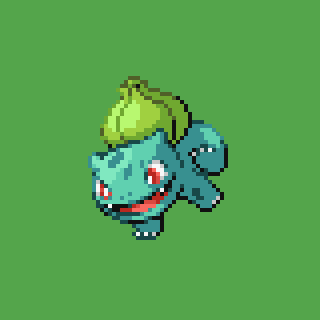

In [282]:
## Load image with PIL
img = Image.open("./DS DSi - Pokemon Platinum - Pokemon 1st Generation.png")
img = img.crop((1, 34, 81, 114))

rle_image = RLEImage.from_image(img)
packed_bin = rle_image.to_bytes()
    
with open("test_rle.bin", "wb") as f:
    f.write(packed_bin)
    print(f"file size: {len(packed_bin)} bytes (data: 0x{hex(len(rle_image.data))})")

display(img.resize(resample=Resampling.BOX, size=(img.width*4, img.height*4)))

### Decoding

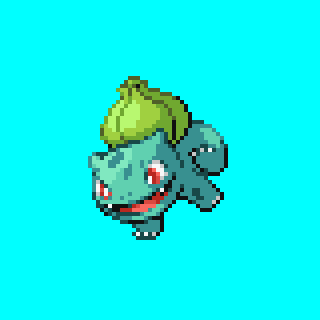

In [283]:
returned_img = rle_image.to_image()
display(returned_img.resize(resample=Resampling.BOX, size=(returned_img.width*4, returned_img.height*4)))

### Merging

upper discard length: 4
now on row 0
discarding 0 pixels
now on row 1
discarding 4 pixels
now on row 2
discarding 4 pixels
now on row 3
discarding 4 pixels
now on row 4
discarding 4 pixels
now on row 5
discarding 4 pixels
now on row 6
discarding 4 pixels
now on row 7
discarding 4 pixels
now on row 8
discarding 4 pixels
now on row 9
discarding 4 pixels
now on row 10
discarding 4 pixels
now on row 11
discarding 4 pixels
now on row 12
discarding 4 pixels
now on row 13
discarding 4 pixels
now on row 14
discarding 4 pixels
now on row 15
discarding 4 pixels
now on row 16
discarding 4 pixels
now on row 17
discarding 4 pixels
now on row 18
discarding 4 pixels
now on row 19
discarding 4 pixels
now on row 20
discarding 4 pixels
now on row 21
discarding 4 pixels
now on row 22
discarding 4 pixels
now on row 23
discarding 4 pixels
now on row 24
discarding 4 pixels
now on row 25
discarding 4 pixels
now on row 26
discarding 4 pixels
now on row 27
discarding 4 pixels
now on row 28
discarding 4 pixels


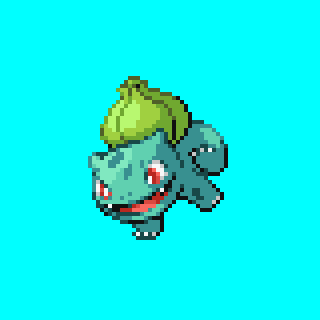

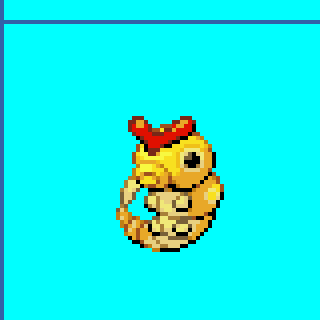

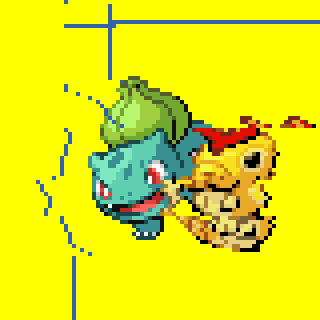

file size: 1620 bytes (data: 0x5f2)


In [284]:
big = Image.open("./DS DSi - Pokemon Platinum - Pokemon 1st Generation.png")
lower = big.crop((1, 34, 81, 114))
upper = big.crop((81, 304, 161, 384))

lower_rle = RLEImage.from_image(lower)
upper_rle = RLEImage.from_image(upper)
lower_back = lower_rle.to_image()
upper_back = upper_rle.to_image()

#print(upper_rle.palette)
#print(lower_rle.header.width*lower_rle.header.height-lower_rle.header.data_size)
thing, thing_rle = lower_rle.merge_to_image(upper_rle, x_offset=4)
display(lower_back.resize(resample=Resampling.BOX, size=(lower_back.width*4, lower_back.height*4)))
display(upper_back.resize(resample=Resampling.BOX, size=(upper_back.width*4, upper_back.height*4)))
display(thing.resize(resample=Resampling.BOX, size=(thing.width*4, thing.height*4)))

with open("test_merged_rle.bin", "wb") as f:
    thing_bytes = thing_rle.to_bytes()
    f.write(thing_bytes)
    print(f"file size: {len(thing_bytes)} bytes (data: {hex(len(thing_rle.data))})")